# Text Generator using RNN
## Novel Generator based on custom fantasy books.
<br> At least 5000 epochs are required before the generated text starts sounding coherent.
<br> *(This model is inspired by many examples, such as Keras samples, or tensorflow tutorials.)*
<br>
<br> Few notices:
<br>- This script is <b>NOT</b> designed for large text.
<br>- This script is designed for ANY language. (It works for my language, at least.)
<br>- It is recommended to run this script on GPU, as recurrent networks are quite computationally intensive.

In [1]:
import time
import chardet
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.seq2seq import sequence_loss

%matplotlib inline

C:\Users\jungw\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Class Details (EN)
- \_\_init\_\_: Load file with encoding option.
    - Default Encoding: None
- Slice_Data: Split text data into characters (This can be words if modified correctly)
- Data2idx: Transform text data into index
- Build_Data: Generate sequences of transformed text data
    - Default Stride: 1
- LSTM_Cell: A LSTM cell, only to use at rnn.MultiRNNCell
- Make_Text: A random text generator, based on text data
- Elapsed: To calculate time elapsed
- Save_Model: Save current Neural Network model
    - Default Global_step: 1000
- Load_Model: Load specified model file
- Plot_Iter_Loss: Plot loss compared to total iteration, using matplotlib.
- Plot_Time_Loss: Plot loss compared to time, usinb matplotlib.
- Prepare_Model: Generate model structure for training (X, Y, weight, etc.)
- Train: Start training model with epoch number followed

### Class Details (KR)
- \_\_init\_\_: 인코딩(Encoding) 옵션과 함께 파일을 로드합니다.
    - 기본 인코딩: None
- Slice_Data: 텍스트를 글자 단위로 분할합니다. (올바른 방법으로 수정할 경우, 단어 단위로도 가능)
- Data2idx: 텍스트 데이터를 인덱스(Index)로 변환합니다.
- Build_Data: 변환된 텍스트 데이터를 기반으로 시퀀스를 생성합니다.
    - 기본 Stride: 1
- LSTM_Cell: rnn.MultiRNNCell에서 쓰이는 LSTM 셀 구조
- Make_Text: 텍스트 데이터를 기반으로 텍스트를 생성합니다.
- Elapsed: 작업 경과시간 측정 용도
- Save_Model: 현재 모델을 저장합니다.
    - Default Global_step: 1000
- Load_Model: 특정 모델 파일을 불러옵니다.
- Plot_Iter_Loss: Matplotlib을 사용하여 Iteration대비 Loss를 그래프로 그려줍니다.
- Plot_Time_Loss: Matplotlib을 사용하여 시간대비 Loss를 그래프로 그려줍니다.
- Prepare_Model: 학습을 위한 모델 구조를 생성합니다. (X, Y, weight 등)
- Train: 지정된 Epoch숫자만큼 학습을 진행합니다.

In [2]:
class TextGen:
    def __init__(self, full_filename, encode=False):
        try:
            read_file = open(full_filename, 'rb').read()
            if encode is True:
                encode_type = chardet.detect(read_file)['encoding']
                print(encode_type)
            else:
                encode_type = None
            # text = open(full_filename, encoding=None).read().lower()
            text = open(full_filename, encoding=encode_type).read()
            self.text = text
        except:
            self.text = False

    def Slice_Data(self):
        print("Word Slicing...")
        self.char_set = sorted(list(set(self.text)))    # character split
        self.char_indices = dict((c, i) for i, c in enumerate(self.char_set))
        self.indices_char = dict((i, c) for i, c in enumerate(self.char_set))

    def Data2idx(self):
        idx_text = []
        for char in self.text:
            idx_text.append(self.char_indices[char])
        self.text = idx_text

    def Build_Data(self, seq_len, stride = 1):
        print("Generating Number Index...")
        x_data = []
        y_data = []
        for i in range(0, len(self.text) - self.seq_len, stride):
            fill_x = seq_len - len(self.text[i : i+seq_len])
            fill_y = seq_len - len(self.text[i+1 : i+seq_len - 1])
            
            x_text = self.text[i : i+seq_len]
            y_text = self.text[i+1 : i+seq_len - 1]
            
            if fill_x is not 0:
                x_text.extend([0 for i in range(fill_x)])
            elif fill_y is not 0:
                y_text.extend([0 for i in range(fill_y)])

            x_data.append(x_text)
            y_data.append(y_text)
        self.x_data = x_data
        self.y_data = y_data

    def LSTM_Cell(hidden_size):
        # Make a lstm cell with hidden_size (each unit output vector size)
        cell = rnn.BasicLSTMCell(hidden_size, state_is_tuple=True)
        return cell

    def Make_Text(self, sess):
        self.results = sess.run(self.outputs, feed_dict={self.X: self.x_data})
        for j, result in enumerate(self.results):
            index = np.argmax(result, axis=1)
            if j is 0:  # print all for the first result to make a sentence
                print(''.join([self.indices_char[t] for t in index]), end='')
            else:
                print(self.indices_char[index[-1]], end='')

    def Elapsed(start, end):
        total = end - start
        m, s = divmod(total, 60)
        h, m = divmod(m, 60)
        
        if m == 0 and h == 0:
            print("Time Elapsed: {:>3d} sec".format(int(s)))
        elif m != 0 and h == 0:
            print("Time Elapsed: {:>3d} min {:>3d} sec".format(int(m), int(s)))
        else:
            print("Time Elapsed: {:>3d} hour {:>3d} min {:>3d} sec".format(int(h), int(m), int(s)))
            
    def Save_Model(saver, sess, filepath, step=1000):
        save_model = saver.save(sess, filepath, global_step=step)
        print("Model saved in path: %s" % save_model)
        
    def Load_Model(saver, sess, filepath):
        saver.restore(sess, filepath)
        print("Model restored.")
        
    def Plot_Iter_Loss(self):
        plt.figure()
        plt.plot(self.iter_loss)
        plt.grid()
        plt.xlabel('Iter')
        plt.ylabel('Loss')
        plt.title('Loss vs Epoch')
        plt.show()
        
    def Plot_Time_Loss(self):
        plt.figure()
        plt.plot(self.elapsed_loss[0], self.elapsed_loss[1])
        plt.grid()
        plt.xlabel('Time(sec)')
        plt.ylabel('Loss')
        plt.title('Loss vs Time')
        plt.show()
        
    def Plot_Time_Iter(self):
        plt.figure()
        plt.plot(self.elapsed_loss[0])
        plt.grid()
        plt.xlabel('Iter')
        plt.ylabel('Time')
        plt.title('Iter vs Time')
        plt.show()

    def Prepare_Model(self, seq_len, learning_rate=0.1):
        self.seq_len = seq_len

        # load data
        TextGen.Slice_Data(self)
        TextGen.Data2idx(self)
        TextGen.Build_Data(self, seq_len)

        self.data_dim = len(self.char_set)
        self.hidden_size = len(self.char_set)
        self.num_classes = len(self.char_set)
        self.learning_rate = learning_rate

        print("Text length: %s" % len(self.text))
        print("Character set length: %s" % self.data_dim)    # length check
        print("Dataset X length: %s" % len(self.x_data))    # dataset shape check
        print("Dataset Y length: %s" % len(self.y_data))

        self.batch_size = len(self.x_data)

        self.X = tf.placeholder(tf.int32, [None, self.seq_len])
        self.Y = tf.placeholder(tf.int32, [None, self.seq_len])

        # One-hot encoding
        X_one_hot = tf.one_hot(self.X, self.num_classes)

        # Make a lstm cell with hidden_size (each unit output vector size)
        lstm = TextGen.LSTM_Cell(self.hidden_size)
        multi_cells = rnn.MultiRNNCell([lstm for _ in range(2)], state_is_tuple=True)

        # outputs: unfolding size x hidden size, state = hidden size
        outputs, _states = tf.nn.dynamic_rnn(multi_cells, X_one_hot, dtype=tf.float32)

        # FC layer
        X_for_fc = tf.reshape(outputs, [-1, self.hidden_size])
        outputs = fully_connected(X_for_fc, self.num_classes, activation_fn=None)

        # reshape out for sequence_loss
        self.outputs = tf.reshape(outputs, [self.batch_size, self.seq_len, self.num_classes])

        # All weights are 1 (equal weights)
        weights = tf.ones([self.batch_size, self.seq_len])

        loss = sequence_loss(logits=self.outputs, targets=self.Y, weights=weights)
        self.mean_loss = tf.reduce_mean(loss)
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.mean_loss)

    def Train(self, sess, epoch, save_at):
        saver = tf.train.Saver()
        
        sess.run(tf.global_variables_initializer())
        print('=' * 20, "{:^20}".format("Training Start"), '=' * 20)

        self.iter_loss = []
        self.elapsed_loss = []
        self.savepath = save_at
        
        start = time.time()
        for i in range(epoch):
            _, l, results = sess.run(
                [self.train_op, self.mean_loss, self.outputs],
                feed_dict={self.X: self.x_data, self.Y: self.y_data})
            for j, result in enumerate(results):
                index = np.argmax(result, axis=1)
                
                if i % 100 == 0 and j == 0:
                    print("\n At step", i, ':',
                        ''.join([self.indices_char[t] for t in index]))
                    print('Loss:', l)
                    end = time.time()
                    TextGen.Elapsed(start, end)
            if i % 1000 == 0:
                TextGen.Save_Model(saver, sess, self.savepath)            
            self.iter_loss.append(l)    # Iteration & Loss
            self.elapsed_loss.append([end-start, l])    # Elapsed Time & Loss


        print('=' * 20, "{:^20}".format("Training Complete"), '=' * 20)

In [3]:
if __name__ == "__main__":
    code_gen = TextGen("SAMPLE.py")
    learning_rate = 0.1
    code_gen.Prepare_Model(40, learning_rate)

    sess = tf.Session()
    save_at = "C:/Users/jungw/OneDrive/문서/GitHub/Text_Generation/rnn_text.ckpt"
    epoch = 10001
    
    code_gen.Train(sess, epoch, save_at)
    
    code_gen.Make_Text(sess)

Word Slicing...
Generating Number Index...
Text length: 12033
Character set length: 75
Dataset X length: 11993
Dataset Y length: 11993
====================    Training Start    ====================

 At step 0 : kkkkkkk<kttttttkkkkk*ccEccccccceey%%%%%%
Loss: 4.322005
Time Elapsed:   1 sec
Model saved in path: C:/Users/jungw/OneDrive/문서/GitHub/Text_Generation/rnn_text.ckpt-1000

 At step 100 : ne.te =ls tselnenil_s)sssaa_s
l
nf

ssls
Loss: 1.9289421
Time Elapsed:   1 min  15 sec

 At step 200 : nelrt ipsifeenaonoltb=
rbae_dIN_LOG_tEVE
Loss: 1.0579635
Time Elapsed:   2 min  29 sec

 At step 300 : msort tps=seantonsls'=Frbre_MhN_LOG_wlVE
Loss: 0.9919871
Time Elapsed:   3 min  42 sec

 At step 400 : nsort tpsip.envinon['TF_CPP_MIN_LOG_LEVE
Loss: 0.5692149
Time Elapsed:   4 min  55 sec

 At step 500 : neort tpeif.environ['TF_CPP_MIN_LOG_LEVE
Loss: 0.4956197
Time Elapsed:   6 min   9 sec

 At step 600 : neort tpsis.environ['TF_CPP_MIN_LOG_LEVE
Loss: 0.49175373
Time Elapsed:   7 min  22 sec



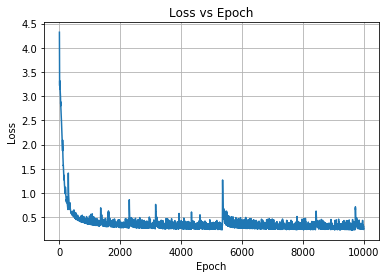

In [10]:
plt.figure()
plt.plot(code_gen.iter_loss)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

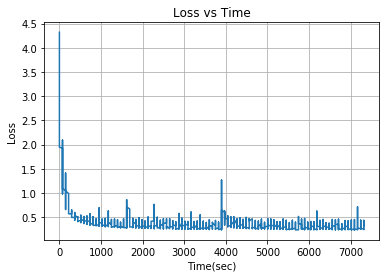

In [16]:
plt.figure()
plt.plot(code_gen.elapsed_loss[0], code_gen.elapsed_loss[1])
plt.grid()
plt.xlabel('Time(sec)')
plt.ylabel('Loss')
plt.title('Loss vs Time')
plt.show()

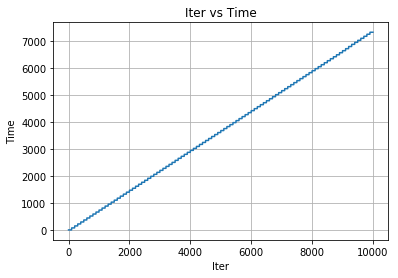

In [19]:
plt.figure()
plt.plot(code_gen.elapsed_loss[0])
plt.grid()
plt.xlabel('Iter')
plt.ylabel('Time')
plt.title('Iter vs Time')
plt.show()